In [1]:
import warnings
warnings.filterwarnings("ignore")

# Point Pattern Analysis


In [2]:
%matplotlib inline

import numpy
import pandas
import geopandas
import pysal
import seaborn
import contextily
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

## Introduction

Points are spatial entities that can be understood in two fundamentally different ways. On the one hand, points can be seen as fixed objects in space, which is to say their location is taken as given (*exogenous*). In this interpretation, the location of an observed point is considered as secondary to the value observed at the point. Think of this like measuring the number of cars traversing a given road intersection; the location is fixed, and the data of interest comes from the measurement taken at that location. The analysis of this kind of point data is very similar to that of other types of spatial data such as polygons and lines. On the other hand, an observation occurring at a point can also be thought of as a site of measurement from an underlying geographically-continuous process. In this case, the measurement could theoretically take place anywhere, but was only carried out or conducted in certain locations. Think of this as measuring the length of birds' wings: the location at which birds are measured reflects the underlying geographical process of bird movement and foraging, and the length of the birds' wings may reflect an underlying ecological process that varies by bird. This kind of approach means that both the location and the measurement matter. This is the perspective we will adopt in the rest of the chapter.

When points are seen as events that could take place in several locations but only happen in a few of them, a collection of such events is called a *point pattern*. In this case, the location of points is one of the key aspects of interest for analysis. A good example of a point pattern is geo-tagged photographs: they could technically happen in many locations but we usually find photos tend to concentrate only in a handful of them. Point patterns can be *marked*, if more attributes are provided with the location, or *unmarked*, if only the coordinates of where the event occurred are provided. Continuing the photo example, an unmarked pattern would result if only the location where are taken is used for analysis, while we would be speaking of a marked point pattern if other attributes, such as the time, camera model, or a "image quality score" was provided with the location.

Point pattern analysis is thus concerned with the visualization, description, statistical characterization, and modeling of point patterns, trying to understand the generating process that gives rise and explains the observed data. Common questions in this domain include:

- *What does the pattern look like?* 
- *What is the nature of the distribution of points?* 
- *Is there any structure in the way locations are arranged over space? That is, are events clustered? or are they dispersed?*
- *Why do events occur in those places and not in others?* 

At this point, it is useful to remind ourselves of an important distinction, that between process and pattern. The former relates to the underlying mechanism that is at work to generate the outcome we end up observing. Because of its abstract nature, we do not get to see it. However, in many contexts, the key focus of any analysis is to learn about *what* determines a given phenomenon and *how* those factors combine to generate it. In this context, "process" is associated with the *how*. "Pattern," on the other hand, relates to the result of that process. In some cases, it is the only trace of the process we can observe and thus the only input we have to work with in order to reconstruct it. Although directly observable and, arguably, easier to tackle, pattern is only a reflection of process. The real challenge is not to characterize the former but to use it to work out the latter.

In this chapter, we provide an introduction to point patters through geo-tagged Flickr photos from Tokyo. We will treat the phenomena represented in the data as events: photos could be taken of any place in Tokyo, but only certain locations are captured. Keep in mind this understanding of Tokyo photos is not immutable: one could conceive cases where it makes sense to take those locations as given and look at the properties of each of them ignoring their "event" aspect. However, in this context, we will focus on those questions that relate to location and the collective shape of locations. The use of these tools will allow us to transform a long list of unintelligible XY coordinates into tangible phenomena with a characteristic spatial structure, and to answer questions about the center, dispersion, and clustering of attractions in Tokyo for Flickr users.



## The Tokyo photographs dataset

The rise of new forms of data such as geo-tagged photos uploaded to online services is creating new ways for researchers to study and understand cities. Where do people take pictures? When are those pictures taken? Why do certain places attract many more photographers than others? All these questions and more become more than just rhetorical ones when we consider, for example,  online photo hosting services as volunteered geographic information (VGI, {cite}`Goodchild2007citizens`). In this chapter we will explore metadata from a sample of geo-referenced images uploaded to [Flickr](https://www.flickr.com/) and extracted thanks to the [100m Flickr dataset](https://webscope.sandbox.yahoo.com/catalog.php?datatype=i&did=67). In doing so, we will introduce a few approaches that help us better understand the distribution and characteristics of a point pattern. 

To get started, let's load the Flickr data first:

In [3]:
db = pandas.read_csv('../data/tokyo/tokyo_clean.csv')

The table contains the following information about the sample of 10,000 photographs: the ID of the user who took the photo; the location expressed as latitude and longitude columns; a transformed version of those coordinates expressed in Pseudo Mercator; the timestamp when the photo was taken; and the URL where the picture they refer to is stored online:

In [4]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               10000 non-null  object 
 1   longitude             10000 non-null  float64
 2   latitude              10000 non-null  float64
 3   date_taken            10000 non-null  object 
 4   photo/video_page_url  10000 non-null  object 
 5   x                     10000 non-null  float64
 6   y                     10000 non-null  float64
dtypes: float64(4), object(3)
memory usage: 547.0+ KB


Note that the data is provided as a `.csv` file, so the spatial information is encoded as separate columns, one for each coordinate. This is contrast to how we have consumed spatial data in previous chapters, where spatial information was stored in a single column and encoded in geometry objects.


## Visualization


### Dots on a map

The first step to get a sense of what the spatial dimension of this dataset looks like is to plot it. At its most basic level, we can generate a scatter plot with `seaborn`:


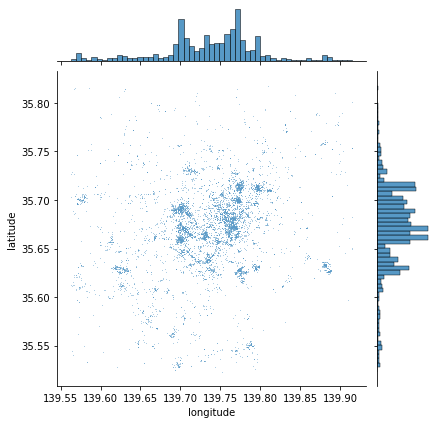

In [5]:
# Generate scatter plot
seaborn.jointplot(x='longitude', y='latitude', data=db, s=0.5);

This is a good start: we can see dots tend to be concentrated in the center of the covered area in a non-random pattern. Furthermore, within the broad pattern, we can also see there seems to be more localized clusters. However, the plot above has two key drawbacks: one, it lacks geographical context; and two, there are areas where the density of points is so large that it is hard to tell anything beyond a blue blurb. 

Start with the context. The easiest way to provide additional context is by overlaying a tile map from the internet. Let us quickly call `contextily` for that, and integrate it with `jointplot`:

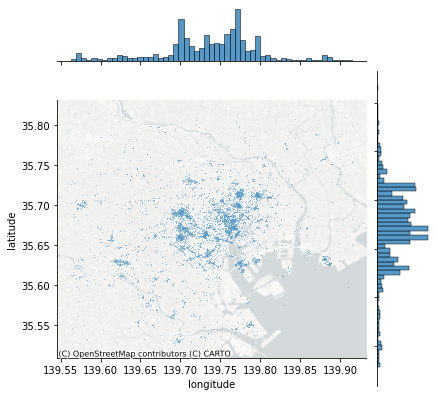

In [6]:
# Generate scatter plot
joint_axes = seaborn.jointplot(
    x='longitude', y='latitude', data=db, s=0.5
)
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels
);

Note how we can pull out the axis where the points are plotted and add the basemap there, specifying the CRS as WGS84, since we are plotting longitude and latitude. Compared to the previous plot, adding a basemap to our initial plot makes the pattern of Flickr data clearer.

### Hex-binning

Consider our second problem: cluttering. When too many photos are concentrated in some areas of, plotting opaque dots on top of one another can make it hard to discern any pattern and explore its nature. For example, in the middle of the map, towards the right, there appears to be the highest concentration of pictures taken; the sheer amount of dots on the maps in some parts obscures whether all of that area receives as many pics or whether, within there, some places receive a particularly high degree of attention.

One solution to get around cluttering relates to what we referred to earlier as moving from {ref}`"tables to surfaces" <ch03-surfaces_as_tables>`. We can now recast this approach as a *spatial* or *2-dimensional histogram*. Here, we generate a regular grid (either squared or hexagonal), count how many dots fall within each grid cell, and present it as we would any other choropleth. This is attractive because it is simple, intuitive and, if fine enough, the regular grid removes some of the area distortions choropleth maps may induce. For this illustration, let us use use hexagonal binning (sometimes called hexbin) because it has slightly nicer properties than squared grids, such as less shape distortion and more regular connectivity between cells. Creating a hexbin 2-d histogram is straightforward in Python using the `hexbin` function:


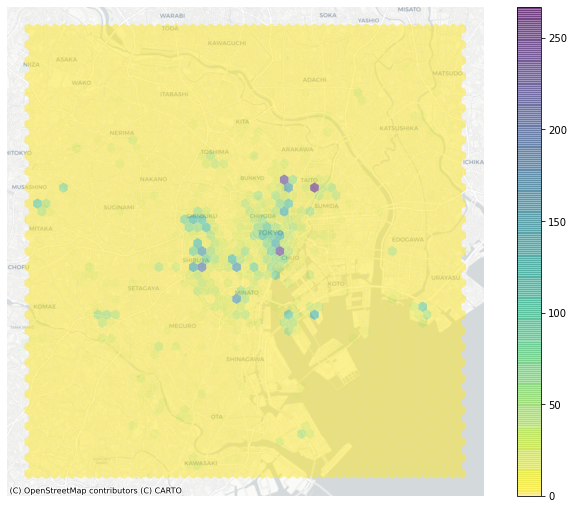

In [7]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))
# Generate and add hexbin with 50 hexagons in each 
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
hb = ax.hexbin(
    db['x'], 
    db['y'],
    gridsize=50, 
    linewidths=0,
    alpha=0.5, 
    cmap='viridis_r'
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Positron
)
# Add colorbar
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()

Voila, this allows a lot more detail! It is now clear that the majority of photographs relate to much more localized areas and that the previous map was obscuring this.

### Kernel Density Estimation (KDE)

Grids are the spatial equivalent of a histogram: the user decides how many "buckets", and the points are counted within them in a discrete fashion. This is fast, efficient, and potentially very detailed (if many bins are created). However, it does represent a discretization of an essentially contiguous phenomenon and, as such, it may introduce distortions (e.g., the modifiable areal unit problem {cite}`wong2004`). An alternative approach is to instead create what is known as a kernel density estimation (KDE): an empirical approximation of the probability density function. This approach is covered in detail elsewhere (e.g. {cite}`Silverman1986density`), but we can provide the intuition here. Instead of overlaying a grid of squares of hexagons and count how many points fall within each, a KDE lays a grid of points over the space of interest on which it places kernel functions that count points around them with different weight based on the distance. These counts are then aggregated to generate a global surface with probability. The most common kernel function is the Gaussian one, which applies a normal distribution to weight points. The result is a continuous surface with a probability function that may be evaluated at every point. Creating a Gaussian kernel in Python is rather straightforward:


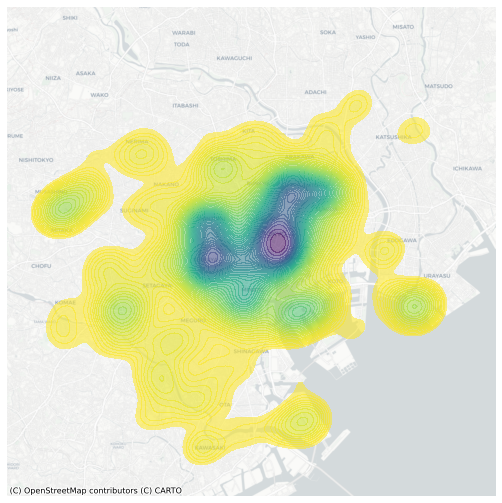

In [8]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Generate and add KDE with a shading of 50 gradients 
# coloured contours, 75% of transparency,
# and the reverse viridis colormap
seaborn.kdeplot(
    db['x'], 
    db['y'],
    n_levels=50, 
    shade=True,
    alpha=0.55, 
    cmap='viridis_r'
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()

The result is a smoother output that captures the same structure of the hexbin but "eases" the transitions between different areas. This provides a better generalization of the theoretical probability distribution over space.  Technically, the continuous nature of the KDE function implies that for any given point the probability of an event is 0. However, as the area around a point increases, the probability of an event within that area can be obtained.  This is useful in some cases, but is mainly of use to escape the restrictions imposed by a regular grid of hexagons or squares. 

## Centrography

Centrography is the analysis of centrality in a point pattern. By "centrality," we mean the general location and dispersion of the pattern. If the hexbin above can be seen as a "spatial histogram", centrography is the point pattern equivalent of measures of central tendency such as the mean. These measures are useful because they allow us to summarize spatial distributions in smaller sets of information (e.g. a single point). Many different indices are used in centrography to provide an indication of "where" a point pattern is, how tightly the point pattern clusters around its center, or how irregular its shape is. 


### Tendency

A common measure of central tendency for a point pattern is its *center of mass*. For marked point patterns, the center of mass identifies a central point close to observations that have higher values in their marked attribute. For unmarked point patterns, the center of mass is equivalent to the *mean center*, or average of the coordinate values. In addition, the *median center* is analogous to the *median* elsewhere, and represents a point where half of the data is above or below the point & half is to its left or right. We can analyze the mean center with our Flickr point pattern using the `pointpats` package in Python. 


In [9]:
from pointpats import centrography

In [10]:
mean_center = centrography.mean_center(db[['x', 'y']])
med_center = centrography.euclidean_median(db[['x', 'y']])

It is easiest to visualize this by plotting the point pattern and its mean center alongside one another:


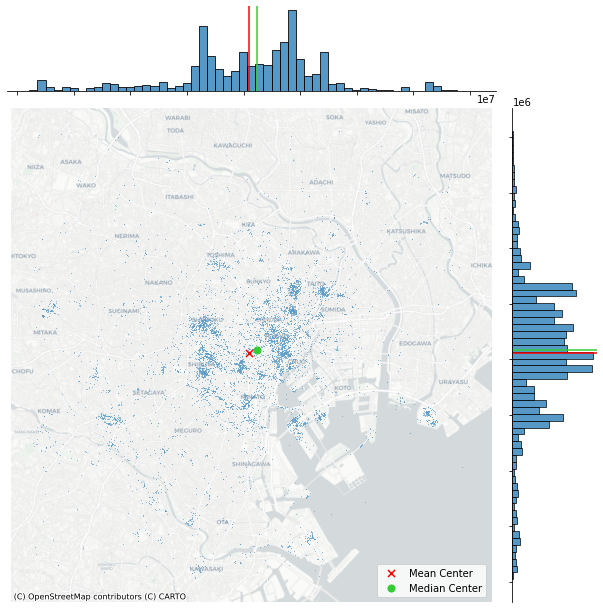

In [11]:
# Generate scatter plot
joint_axes = seaborn.jointplot(
    x='x', y='y', data=db, s=0.75, height=9
)
# Add mean point and marginal lines
joint_axes.ax_joint.scatter(
    *mean_center, color='red', marker='x', s=50, label='Mean Center'
)
joint_axes.ax_marg_x.axvline(mean_center[0], color='red')
joint_axes.ax_marg_y.axhline(mean_center[1], color='red')
# Add median point and marginal lines
joint_axes.ax_joint.scatter(
    *med_center, color='limegreen', marker='o', s=50, label='Median Center'
)
joint_axes.ax_marg_x.axvline(med_center[0], color='limegreen')
joint_axes.ax_marg_y.axhline(med_center[1], color='limegreen')
# Legend
joint_axes.ax_joint.legend()
# Add basemap
contextily.add_basemap(
    joint_axes.ax_joint, 
    source=contextily.providers.CartoDB.Positron
)
# Clean axes
joint_axes.ax_joint.set_axis_off()
# Display
plt.show()

The discrepancy between the two centers is caused by the skew; there are many "clusters" of pictures far out in West and South Tokyo, whereas North and East Tokyo is densely packed, but drops off very quickly. Thus, the far out clusters of pictures pulls the mean center to the west and south, relative to the median center. 


### Dispersion

A measure of dispersion that is common in centrography is the *standard distance*. This measure provides the average distance away from the center of the point cloud (such as measured by the center of mass). This is also simple to compute using `pointpats`, using the `std_distance` function:


In [12]:
centrography.std_distance(db[['x','y']])

8778.218564382098

This means that, on average, pictures are taken around 8800 meters away from the mean center. 

Another helpful visualization is the *standard deviational ellipse*, or *standard ellipse*. This is an ellipse drawn from the data that reflects its center, dispersion, and orientation. To visualize this, we first compute the axes and rotation using the `ellipse` function in `pointpats`:


In [13]:
major, minor, rotation = centrography.ellipse(db[['x','y']])

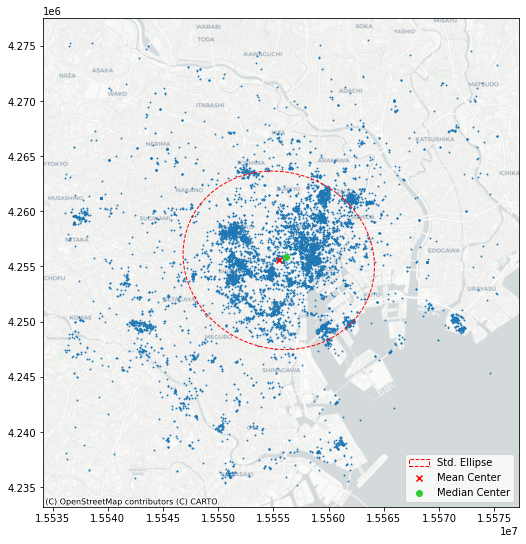

In [14]:
from matplotlib.patches import Ellipse

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot photograph points
ax.scatter(db['x'], db['y'], s=0.75)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

# Construct the standard ellipse using matplotlib
ellipse = Ellipse(xy=mean_center, # center the ellipse on our mean center
                  width=major*2, # centrography.ellipse only gives half the axis
                  height=minor*2, 
                  angle = numpy.rad2deg(rotation), # Angles for this are in degrees, not radians
                  facecolor='none', 
                  edgecolor='red', linestyle='--',
                  label='Std. Ellipse')
ax.add_patch(ellipse)

ax.legend()
# Display
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Positron
)
plt.show()

### Extent

The last collection of centrography measures we will discuss characterizes the extent of a point cloud. Four shapes are useful, and reflect varying levels of how "tightly" they bind the pattern. 

Below, we'll walk through how to construct each example and visualize them at the end. To make things more clear, we'll use the Flickr photos for the most prolific user in the dataset (ID: `95795770`) to show how different these results can be.


In [15]:
user = db.query('user_id == "95795770@N00"')
coordinates = user[['x','y']].values

First, we'll compute the **convex hull**, which is the tightest *convex* shape that encloses the user's photos. By *convex*, we mean that the shape never "doubles back" on itself; it has no divets, valleys, crenelations, or holes. All of its interior angles are smaller than 180 degrees.  This is computed using the `centrography.hull` method.


In [16]:
convex_hull_vertices = centrography.hull(coordinates)

Second, we'll compute the **alpha shape**, which can be understood as a "tighter" version of the convex hull. One way to think of a convex hull is that it's the space left over when rolling a **really** large ball or circle all the way around the shape. The ball is so large relative to the shape, its radius is actually infinite, and the lines forming the convex hull are actually just straight lines! 

In contrast, you can think of an alpha shape as the space made from rolling a *small* balls around the shape. Since the ball is smaller, it rolls into the dips & valleys created between points. As that ball gets bigger, the alpha shape becomes the convex hull. But, for small balls, the shape can get very tight indeed. In fact, if alpha gets too small, it "slips" through the points, resulting in *more than one hull!* As such, the `pysal` package has an `alpha_shape_auto` function to find the smallest *single* alpha shape, so that you don't have to guess at how big the ball needs to be. 


In [17]:
import libpysal
alpha_shape, alpha, circs = libpysal.cg.alpha_shape_auto(coordinates, return_circles=True)

To illustrate, the figure below has the tightest single alpha shape shown in green and the original source points shown in black. The "bounding" circles shown in the figure all have a radius of $8652$ meters. The circles are plotted where our "bounding" disk touches two or three of the points in the point cloud. You can see that the circles "cut into" the convex hull, shown in blue dashed lines, up until they touch two (or three) points. Any tighter, and the circle would disconnect one of the points on the boundary of the alpha shape. 


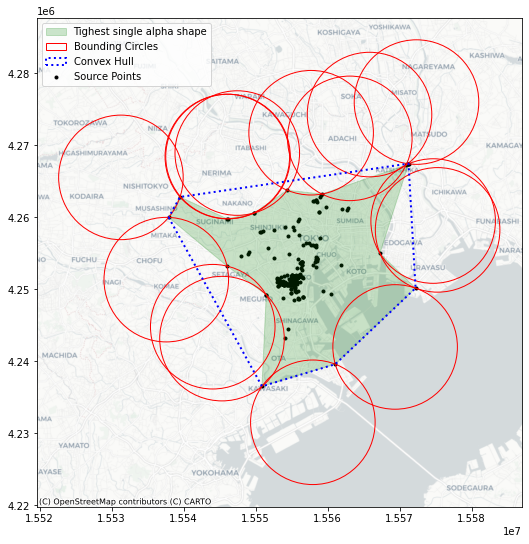

In [18]:
from descartes import PolygonPatch #to plot the alpha shape easily
f,ax = plt.subplots(1,1, figsize=(9,9))

# Plot a green alpha shape
ax.add_patch(
    PolygonPatch(
        alpha_shape, 
        edgecolor='green', 
        facecolor='green', 
        alpha=.2, 
        label = 'Tighest single alpha shape'
    )
)

# Include the points for our prolific user in black
ax.scatter(
    *coordinates.T, color='k', marker='.', label='Source Points'
)

# plot the circles forming the boundary of the alpha shape
for i, circle in enumerate(circs):
    # only label the first circle of its kind
    if i == 0:
        label = 'Bounding Circles'
    else:
        label = None
    ax.add_patch(
        plt.Circle(
            circle, 
            radius=alpha, 
            facecolor='none', 
            edgecolor='r', 
            label=label
        )
    )

# add a blue convex hull
ax.add_patch(
    plt.Polygon(
        convex_hull_vertices, 
        closed=True, 
        edgecolor='blue', 
        facecolor='none', 
        linestyle=':', 
        linewidth=2,
        label='Convex Hull'
    )
)

# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Positron
)

plt.legend();

We will cover three more bounding shapes, all of them rectangles or circles. First, two kinds of **minimum bounding rectangles**. They both are constructed as the tightest *rectangle* that can be drawn around the data that contains all of the points. One kind of minimum bounding rectangle can be drawn just by considering vertical and horizontal lines. However, diagonal lines can often be drawn to construct a rectangle with a smaller area. This means that the **minimum rotated rectangle** provides a tighter rectangular bound on the point pattern, but the rectangle is askew or rotated. 

For the minimum rotated rectangle, we will use the `minimum_rotated_rectangle` function from the `pointpats.centrography` module. 


In [19]:
# Commented out until functionality is added to pointpats
#min_rot_rect = centrography.minimum_rotated_rectangle(coordinates)

And, for the minimum bounding rectangle without rotation, we will use the `minimum_bounding_rectangle` function from the `pointpats` package.


In [20]:
min_rect_vertices = centrography.minimum_bounding_rectangle(coordinates)

Finally, the **minimum bounding circle** is the smallest circle that can be drawn to enclose the entire dataset. Often, this circle is bigger than the minimum bounding rectangle. It is implemented in the `minimum_bounding_circle` function in `pointpats`. 


In [21]:
(center_x, center_y), radius = centrography.minimum_bounding_circle(coordinates)

Now, to visualize these, we'll convert the raw vertices into `matplotlib` patches: 


In [22]:
from matplotlib.patches import Polygon, Circle, Rectangle
from descartes import PolygonPatch

# Make a purple alpha shape
alpha_shape_patch = PolygonPatch(
    alpha_shape, 
    edgecolor='purple', 
    facecolor='none', 
    linewidth=2,
    label='Alpha Shape'
)

# a blue convex hull
convex_hull_patch = Polygon(
    convex_hull_vertices, 
    closed=True, 
    edgecolor='blue', facecolor='none', 
    linestyle=':', linewidth=2,
    label='Convex Hull'
)

# a green minimum rotated rectangle
"""
# Commented out until functionality is added to pointpats
min_rot_rect_patch = Polygon(
    min_rot_rect, 
    closed=True, 
    edgecolor='green', 
    facecolor='none', 
    linestyle='--', 
    label='Min Rotated Rectangle', 
    linewidth=2
)
"""

# compute the width and height of the 
min_rect_width = min_rect_vertices[2] - min_rect_vertices[0]
min_rect_height = min_rect_vertices[2] - min_rect_vertices[0]

# a goldenrod minimum bounding rectangle
min_rect_patch = Rectangle(
    min_rect_vertices[0:2], 
    width = min_rect_width,
    height = min_rect_height,
    edgecolor='goldenrod', facecolor='none', 
    linestyle='dashed', linewidth=2, 
    label='Min Bounding Rectangle', 
)

# and a red minimum bounding circle
circ_patch = Circle(
    (center_x, center_y), 
    radius=radius,
    edgecolor='red', 
    facecolor='none', 
    linewidth=2,
    label='Min Bounding Circle'
)

Finally, we'll plot the patches together with the photograph locations below:


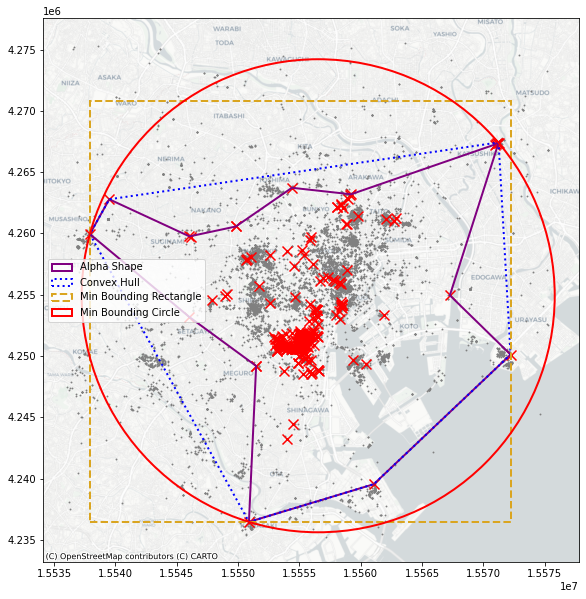

In [23]:
f,ax = plt.subplots(1, figsize=(10,10))

ax.add_patch(alpha_shape_patch)
ax.add_patch(convex_hull_patch)
# Commented out until functionality is added to pointpats
#ax.add_patch(min_rot_rect_patch)
ax.add_patch(min_rect_patch)
ax.add_patch(circ_patch)

ax.scatter(db.x, db.y, s=.75, color='grey')
ax.scatter(user.x, user.y, s=100, color='r', marker='x')
ax.legend(ncol=1, loc='center left')

# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Positron
)
plt.show()

Each gives a different impression of the area enclosing the user's range of photographs. In this, you can see that the the alpha shape is much tighter than the rest of the shapes. The minimum bounding rectangle & circle are the "loosest" shapes, in that they contain the most area outside of the user's typical area. But, they're also the simplest shapes to draw and understand. 



## Randomness & clustering

Beyond questions of centrality and extent, spatial statistics on point patterns are often concerned with how *even* a distribution of points is. By this, we mean whether points tend to all cluster near one another or disperse evenly throughout the problem area. Questions like this refer to the *intensity* or *dispersion* of the point pattern overall. In the jargon of the last two chapters, this focus resembles the goals we examined when we introduced [global spatial autocorrelation](06_spatial_autocorrelation): what is the overall degree of *clustering* we observe in the pattern? Spatial statistics has devoted plenty of effort to understand this kind of clustering. This section will cover methods useful for identifying clustering in point patterns.

The first set of techniques, **quadrat** statistics, receive their name after their approach to split the data up into small areas (quadrants). Once created, these "buckets" are used to examinee the uniformity of counts across them. The second set of techniques all derive from Ripley (1988), and involve measurements of the distance between points in a point pattern. 


In [24]:
from pointpats import distance_statistics, QStatistic, random, PointPattern

For the purposes of illustration, it also helps to provide a pattern derived from a known *completely spatially random* process. That is, the location and number of points is totally random; there is neither clustering nor dispersion. In point pattern analysis, this is known as a *Poisson point process*. 

To simulate these processes from a given point set, you can use the `pointpats.random` module. 


In [25]:
random_pattern = random.poisson(coordinates, size=len(coordinates))

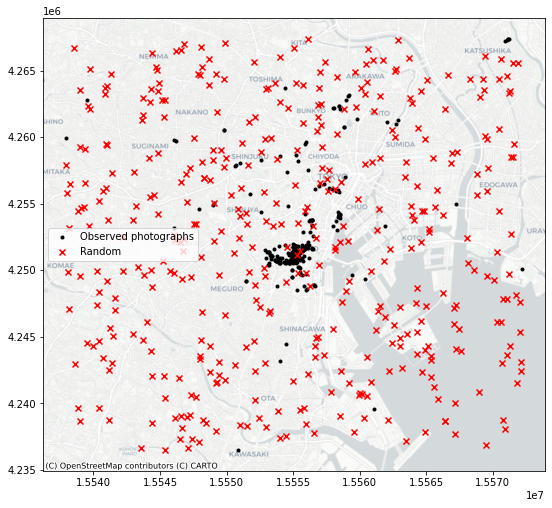

In [26]:
f,ax = plt.subplots(1, figsize=(9, 9))
plt.scatter(*coordinates.T, color='k', marker='.', label='Observed photographs')
plt.scatter(*random_pattern.T, color='r', marker='x', label='Random')
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Positron
)
ax.legend(ncol=1, loc='center left')
plt.show()

As you can see, the simulation (by default) works with the bounding box of the input point pattern. To simulate from more restricted areas formed by the point pattern, pass those hulls to the simulator! For example, to generate a random pattern within the alpha shapes: 


In [27]:
random_pattern_ashape = random.poisson(alpha_shape, size=len(coordinates))

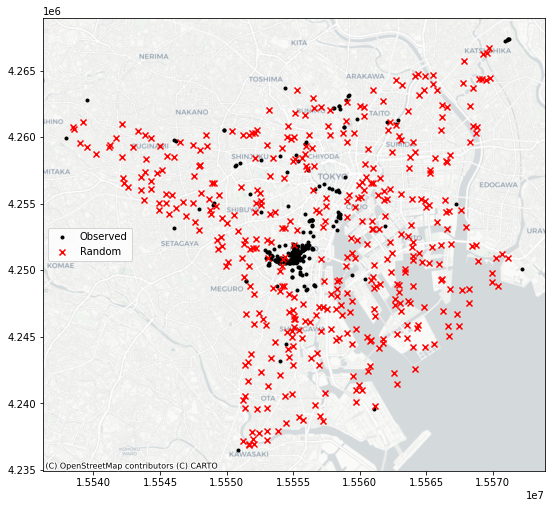

In [28]:
f,ax = plt.subplots(1, figsize=(9, 9))
plt.scatter(*coordinates.T, color='k', marker='.', label='Observed')
plt.scatter(*random_pattern_ashape.T, color='r', marker='x', label='Random')
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Positron
)
ax.legend(ncol=1, loc='center left')
plt.show()

### Quadrat statistics

Quadrat statistics examine the spatial distribution of points in an area in terms of the count of observations that fall within a given cell. By examining whether observations are spread *evenly* over cells, the quadrat approach aims to estimate whether points are spread out, or if they are clustered into a few cells. Strictly speaking, quadrat statistics examine the *evenness* of the distribution over cells using a $\chi^2$ statistical test common in the analysis of contingency tables. 

In the `pointpats` package, you can visualize the results using the following `QStatistic.plot()` method. This shows the grid used to count the events, as well as the underlying pattern:


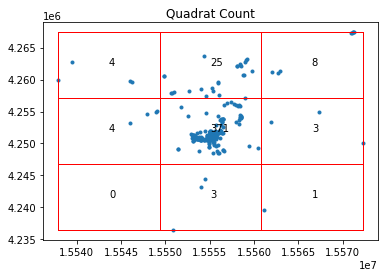

In [29]:
qstat = QStatistic(coordinates)
qstat.plot()

In this case, for the default of a three by three grid spanning the point pattern, we see that the central square has over 350 observations, but the surrounding cells have many fewer Flickr photographs. This means that the chi-squared test (which compares how likely this distribution is if the cell counts are uniform) will be statistically significant, with a very small p-value:


In [30]:
qstat.chi2_pvalue

0.0

In contrast, our totally random point process will have nearly the same points in every cell:


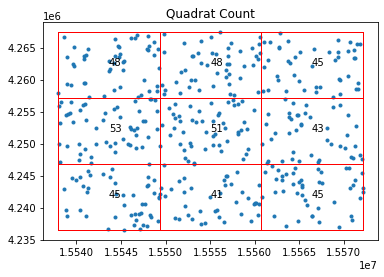

In [31]:
qstat_null = QStatistic(random_pattern)
qstat_null.plot()

This means its p-value will be large, and likely not significant:


In [32]:
qstat_null.chi2_pvalue

0.9618976755879519

Be careful, however: the fact that quadrat counts are measured in a *regular tiling* that is overlaid on top of the potentially irregular extent of our pattern can mislead us. In particular, irregular *but random* patterns can be mistakenly found "significant" by this approach. Consider our random set generated within the alpha shape polygon, with the quadrat grid overlaid on top:

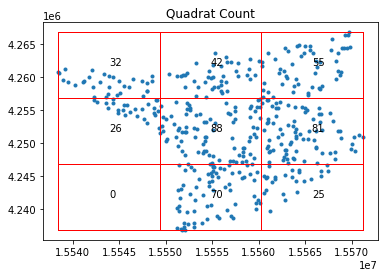

In [33]:
qstat_null_ashape = QStatistic(random_pattern_ashape)
qstat_null_ashape.plot()

The quadrat test finds this to be *statistically nonrandom*, while our simulating process ensured that *within the given study area*, the pattern is a complete spatially-random process. 

In [34]:
qstat_null_ashape.chi2_pvalue

1.1446106336337376e-27

Thus, quadrat counts can have issues with irregular study areas, and care should be taken to ensure that clustering is not mistakenly identified. One way to interpret the quadrat statistic that reconciles cases like the one above is to think of it as a test that considers both the uniformity of points *and* the shape of their extent to examine whether the resulting pattern is uniform across a regular grid. In some cases, this is a useful tool; in others this needs to be used with caution.

### Ripley's alphabet of functions

The second group of spatial statistics we consider focuses on the distributions of two quantities in a point pattern: nearest neighbor distances and what we will term "gaps" in the pattern. They derive from seminal work by {cite}`Ripley1991` on how to characterize clustering or co-location in point patterns. Each of these characterize an aspect of the point pattern as we increase the distance range from each point to calculate them. 

The first function, Ripley's $G$, focuses on the distribution of nearest neighbor distances. That is, the $G$ function summarizes the distances between each point in the pattern and their nearest neighbor. In the plot below, this nearest neighbor logic is visualized with the red dots being a detailed view of the point pattern and the black arrows indicating the nearest neighbor to each point. Note that sometimes two points are *mutual* nearest neighbors (and so have arrows going in both directions) but some are not. 


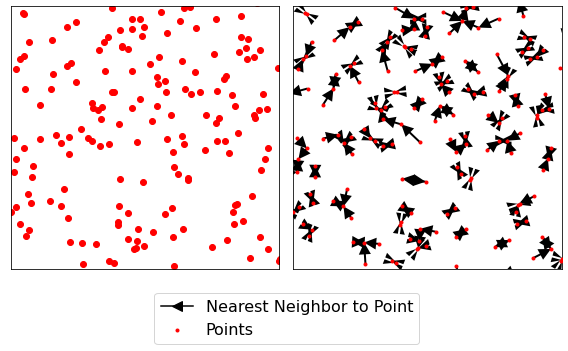

In [35]:
# this code should be hidden in the book, and only the plot visible!
f,ax = plt.subplots(1,2,figsize=(8,4), sharex=True, sharey=True)
ax[0].scatter(*random_pattern.T, color='red')
ax[1].scatter(*random_pattern.T, color='red',
              zorder=100, marker='.', label='Points')
nn_ixs, nn_ds = PointPattern(random_pattern).knn(1)
first = True
for coord, nn_ix, nn_d in zip(random_pattern, nn_ixs, nn_ds):
    dx, dy = random_pattern[nn_ix].squeeze() - coord
    arrow = ax[1].arrow(*coord, dx,dy, 
                length_includes_head=True, 
                overhang=0, head_length=300*3,
                head_width=300*3, width=50*3,
                linewidth=0, facecolor='k',
                head_starts_at_zero=False)
    if first:
        plt.plot((1e100, 1e101), (0,1), color='k', 
                 marker='<', markersize=10,
                 label='Nearest Neighbor to Point')
    first = False

ax[0].axis([1.554e7, 1.556e7, 4240000, 4260000])
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xticks([])
ax[0].set_yticks([])
f.tight_layout()
ax[1].legend(bbox_to_anchor = (.5,-.06), fontsize=16)
plt.show()

Ripley's $G$ keeps track of the proportion of points for which the nearest neighbor is within a given distance threshold, and plots that cumulative percentage against the increasing distance radii. The distribution of these cumulative percentage has a distinctive shape under completely spatially random processes. The intuition behind Ripley's G goes as follows: we can learn about how similar our pattern is to a spatially random one by computing the cumulative distribution of nearest neighbor distances over increasing distance thresholds, and comparing it to that of a set of simulated patterns that follow a known spatially-random process. Usually, a spatial Poisson point process is used as such reference distribution. 

To do this in the `pointpats` package, we can use the `g_test` function, which computes both the `G` function for the empirical data *and* these hypothetical replications under a completely spatially random process.


In [36]:
g_test = distance_statistics.g_test(
    coordinates, support=40, keep_simulations=True
)

Thinking about these distributions of distances, a "clustered" pattern must have more points near one another than a pattern that is "dispersed"; and a completely random pattern should have something in between. Therefore, if the $G$ function increases *rapidly* with distance, we probably have a clustered pattern. If it increases *slowly* with distance, we have a dispersed pattern. Something in the middle will be difficult to distinguish from pure chance.

We can visualize this below. On the left, we plot the $G(d)$ function, with distance-to-point ($d$) on the horizontal axis and the fraction of nearest neighbor distances smaller than $d$ on the right axis. In red, the empirical cumulative distribution of nearest neighbor distances is shown. In blue, simulations (like the `random` pattern shown in the previous section) are shown. The bright blue line represents the average of all simulations, and the darker blue/black band around it represents the middle 95% of simulations. 

In this plot, we see that the red empirical function rises much faster than simulated completely spatially random patterns. This means that the observed pattern of this user's Flickr photographs are *closer* to their nearest neighbors than would be expected from a completely spatially random pattern. The pattern is *clustered.*


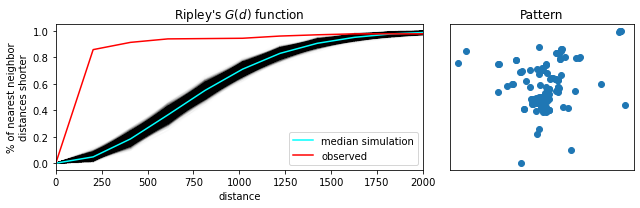

In [37]:
f,ax = plt.subplots(1,2,figsize=(9,3), 
                    gridspec_kw=dict(width_ratios=(6,3)))
# plot all the simulations with very fine lines
ax[0].plot(g_test.support, g_test.simulations.T, color='k', alpha=.01)
# and show the average of simulations
ax[0].plot(g_test.support, numpy.median(g_test.simulations, axis=0), color='cyan', 
         label='median simulation')


# and the observed pattern's G function
ax[0].plot(g_test.support, g_test.statistic, label = 'observed', color='red')

# clean up labels and axes
ax[0].set_xlabel('distance')
ax[0].set_ylabel('% of nearest neighbor\ndistances shorter')
ax[0].legend()
ax[0].set_xlim(0,2000)
ax[0].set_title(r"Ripley's $G(d)$ function")

# plot the pattern itself on the next frame
ax[1].scatter(*coordinates.T)

# and clean up labels and axes there, too
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title('Pattern')
f.tight_layout()
plt.show()

The second function we introduce is Ripley's $F$. Where the $G$ function works by analyzing the distance *between* points in the pattern, the *F* function works by analyzing the distance *to* points in the pattern from locations in empty space. That is why the $F$ function is called the "the empty space function", since it characterizes the typical distance from arbitrary points in empty space to the point pattern. More explicitly, the $F$ accumulates, for a growing distance range, the percentage of points that can be found within that range from a random point pattern generated within the extent of the observed pattern. If the pattern has large gaps or empty areas, the $F$ function will increase slowly. But, if the pattern is highly dispersed, then the $F$ function will increase rapidly. The shape of this cumulative distribution is then compared to those constructed by calculating the same cumulative distribution between the random pattern and an additional, random one generated in each simulation step.

We can use similar tooling to investigate the $F$ function, since it is so mathematically similar to the $G$ function. This is implemented identically using the `f_test` function in `pointpats`. Since the $F$ function estimated for the observed pattern increases *much* more slowly than the $F$ functions for the simulated patterns, we can be confident that there are many gaps in our pattern; i.e. the pattern is *clustered*. 


In [38]:
f_test = distance_statistics.f_test(
    coordinates, support=40, keep_simulations=True
)

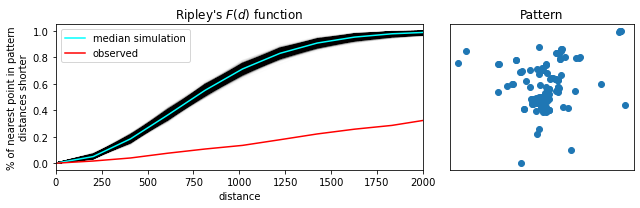

In [39]:
f,ax = plt.subplots(
    1,2,figsize=(9,3), gridspec_kw=dict(width_ratios=(6,3))
)

# plot all the simulations with very fine lines
ax[0].plot(f_test.support, f_test.simulations.T, color='k', alpha=.01)
# and show the average of simulations
ax[0].plot(f_test.support, numpy.median(f_test.simulations, axis=0), color='cyan', 
         label='median simulation')


# and the observed pattern's F function
ax[0].plot(f_test.support, f_test.statistic, label = 'observed', color='red')

# clean up labels and axes
ax[0].set_xlabel('distance')
ax[0].set_ylabel('% of nearest point in pattern\ndistances shorter')
ax[0].legend()
ax[0].set_xlim(0,2000)
ax[0].set_title(r"Ripley's $F(d)$ function")

# plot the pattern itself on the next frame
ax[1].scatter(*coordinates.T)

# and clean up labels and axes there, too
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title('Pattern')
f.tight_layout()
plt.show()

Ripley's "alphabet" extends to several other letter-named functions that can be used for conducting point pattern analysis in this vein. Good "next steps" in your point pattern analysis journey include the book by {cite}`Baddeley2015`; and the `pointpats` documentation for guidance on how to run these in Python.

## Identifying clusters

The previous two sections on exploratory spatial analysis of point patterns provide methods to characterize whether point patterns are dispersed or clustered in space. Another way to see the content in those sections is they help us explore the degree of overall *clustering*. However, knowing that a point pattern is clustered does not necessarily give us information about where that (set of) cluster(s) resides. To do this, we need to switch to a method able to identify areas of high density of points within our pattern. In other words, in this section we focus on the existence and location of *clusters*. This distinction between cluster*ing* and cluster*s* of points is analogue to that discussed in the context of spatial autocorrelation (Chapters [6](06_spatial_autocorrelation) and [7](07_local_autocorrelation). The notion is the same, the differences in the techniques we examine in each part of the book relate to the unique nature of points we referred to in the beginning of the book. Remember that, while the methods we explored in the earlier chapters take the location of the spatial objects (points, lines, polygons) as given and focus on understanding the configurations of values within those locations; the methods discussed in this chapter understand points as events that happen in particular locations but that could happen in a much broader set of places. Factoring in this underlying relevance of the location of an object itself is what makes the techniques in this chapter distinct.

From the many spatial point clustering algorithms, we will cover one called DBSCAN (Density-Based Spatial Clustering of Applications, {cite}`ester1996density`. DBSCAN is a widely used algorithm that originated in the area of knowledge discovery and machine learning and that has since spread into many areas, including the analysis of spatial points. In part, its popularity resides in its intellectual simplicity and computational tractability. In some ways, we can think of DBSCAN as a point pattern counterpart of the local statistics we explored in [Chapter 7](07_local_autocorrelation). They do however differ in fundamental ways. Unlike the local statistics we have seen earlier, DBSCAN is not based on an inferential framework, but it is instead a deterministic algorithm. This implies that, unlike the measures seen before, we will not be able to estimate a measure of the degree to which the clusters found are compatible with cases of spatial randomness.  

From the point of view of DBSCAN, a cluster is a concentration of at least `m` points, each of them within a distance of `r` of at least another point in the cluster. Following this definition, the algorithm classifies each point in our pattern into three categories:

* *Noise*, for those points outside a cluster.
* *Cores*, for those points inside a cluster with at least `m` points in the cluster within distance `r`.
* *Borders* for points inside a cluster with less than `m` other points in the cluster within distance `r`.

The flexibility (but also some of the limitations) of the algorithm resides in that both `m` and `r` need to be specified by the user before running DBSCAN. This is a critical point, as their value can influence significantly the final result. Before exploring this in greater depth, let us get a first run at computing `DBSCAN` in Python:


In [40]:
# Define DBSCAN
clusterer = DBSCAN()
# Fit to our data
clusterer.fit(db[["x", "y"]])

DBSCAN()

Following the standard interface in scikit-learn, we first define the algorithm we want to run (creating the `clusterer` object) and then we *fit* it to our data. Once fit, `clusterer` contains the required information to access all the results of the algorithm. The `core_sample_indices_` attribute contains the indices (order, starting from zero) of each point which is classified as a *core*. We can have a peek into it to see what it looks like:


In [41]:
# Print the first 5 elements of `cs`
clusterer.core_sample_indices_[:5]

array([ 1, 22, 30, 36, 42])

The printout above tells us that the second (remember, Python starts counting at zero!) point in the dataset is a core, as are the 23rd, 31st, 36th, and 43rd points. This attribute has a variable length, depending on how many cores the algorithm finds.

The second attribute of interest is `labels_`:

In [42]:
clusterer.labels_[:5]

array([-1,  0, -1, -1, -1])

The labels object always has the same length as the number of points used to run DBSCAN. Each value represents the index of the cluster a point belongs to. If the point is classified as *noise*, it receives a -1. Above, we can see that the second point belongs to cluster 1, while the others in the list are effectively not part of any cluster. To make thinks easier later on, let us turn the labels into a `Series` object that we can index in the same way as our collection of points:


In [43]:
lbls = pandas.Series(clusterer.labels_, index=db.index)

Now we already have the clusters, we can proceed to visualize them. There are many ways in which this can be done. We will start just by coloring points in a cluster in red and noise in gray:


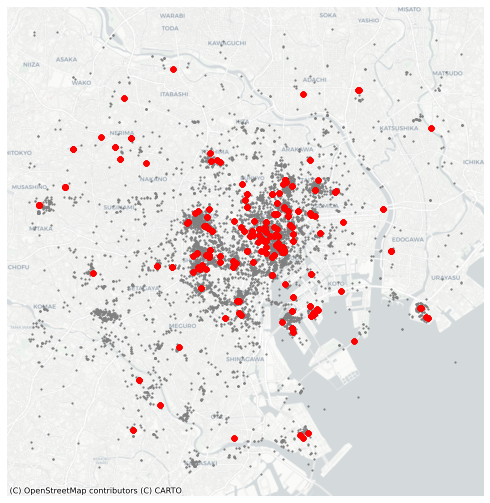

In [44]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Subset points that are not part of any cluster (noise)
noise = db.loc[lbls==-1, ['x', 'y']]
# Plot noise in grey
ax.scatter(noise['x'], noise['y'], c='grey', s=5, linewidth=0)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(db.loc[db.index.difference(noise.index), 'x'], \
           db.loc[db.index.difference(noise.index), 'y'], \
          c='red', linewidth=0)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()

Although informative, the result of this run is not particularly satisfactory. There are *way* too many points that are classified as "noise".

This is because we have run DBSCAN with the default parameters: a radius of 0.5 and a minimum of five points per cluster. Since our data is expressed in meters, a radius of half a meter will only pick up hyper local clusters. This might be of interest in some cases but, in others, it can result in odd outputs. 

If we change those parameters, can pick up more general patterns. For example, let us say a cluster needs to, at least, have roughly 1% of all the points in the dataset:


In [45]:
# Obtain the number of points 1% of the total represents
minp = numpy.round(db.shape[0] * 0.01)
minp

100.0

At the same time, let us expand the maximum radius to say, 500 meters. Then we can re-run the algorithm and plot the output, all in the same cell this time:


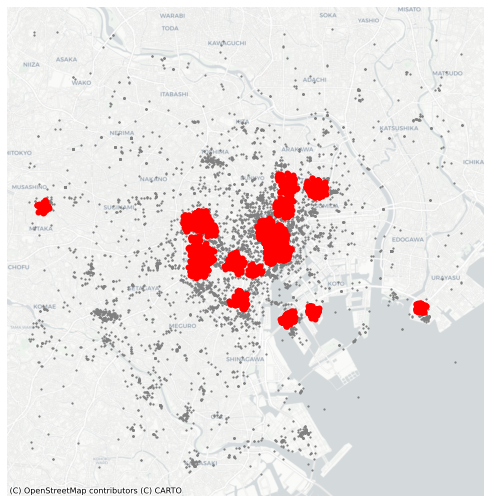

In [46]:
# Rerun DBSCAN
clusterer = DBSCAN(eps=500, min_samples=minp)
clusterer.fit(db[['x', 'y']])
# Turn labels into a Series
lbls = pandas.Series(clusterer.labels_, index=db.index)
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Subset points that are not part of any cluster (noise)
noise = db.loc[lbls==-1, ['x', 'y']]
# Plot noise in grey
ax.scatter(noise['x'], noise['y'], c='grey', s=5, linewidth=0)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (db) and substract from
#      it the index of those that are noise
ax.scatter(
    db.loc[db.index.difference(noise.index), 'x'],
    db.loc[db.index.difference(noise.index), 'y'],
    c='red', 
    linewidth=0
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()

## Conclusion

Overall, this chapter has provided an overview of methods to analyze point patterns. We have begun our point journey by visualizing their location and learning way to overcome the "cluttering" challenge that large point patterns present us with. From graphical display, we have moved to statistical characterization of their spatial distribution. In this context, we have learned about  central tendency dispersion and extent, and we have positioned these measures as the point pattern counterparts of traditional statistics such as the mean or the standard deviation. These measures provide a summary of an entire pattern, but tell us little about the spatial organization of each point. To that end, we have introduced the quadrat and Ripley's functions. These statistical devices help us in characterizing whether a point pattern is spatially clustered or dispersed. We have wrapped up the chapter going one step further and exploring methods to identify the location of clusters: areas of the map with high density of points. Taken altogether, point pattern analysis has many applications across classical statistical fields as well as in data science. Using the techniques discussed here, you should be able to answer fundamental questions about point patterns that represent widely varied phenomena in the world, from the location where photographs where taken to the distribution of bird nests, to the clustering of bike crashes in a city.


## Questions

1. What is the trade-off when picking the hexagon granularity when "hexbinning"? Put another way, can we pick a "good" number of bins for all problems? If not, how would you recommend to select a specific number of bins?
2. Kernel Density Estimation (KDE) gets around the need to partition space in "buckets" to count points inside each of them. But, can you think of the limitations of applying this technique? To explore them, reproduce the KDE figure in the chapter, but change the arguments of the type of kernel (`kernel`) and the size of the bandwidth (`bw`). Consult the documentation of `seaborn.kdeplot` to learn what each of them controls. What happens when the bandwidth is very small? How does that relate to the number of bins in the hexbin plot?
3. Given a hypothetical point pattern, what characteristics would it need to meet for the mean and median centers to coincide? 
4. Using `libpysal.cg.alpha_shape`, plot what happens to the alpha hull for $\alpha = 0,.2,.4,.6,.8,1,1.5,2,4$. What happens as `alpha` increases?
5. The choice of extent definition you adopt may influence your final results significantly. To further internalize this realization, compute the density of photographs in the example we have seen using each of the extent definitions covered (minimum bounding/rotate circle/rectangle, convex hull and alpha shape). Remember the density can be obtained by dividing the number of photographs by the area of the extent.
6. Given the discussions in question 1 and 2, how do you think the density of quadrats affect quadrat statistics?
7. Can you use information from Ripley's functions to inform the choice of DBSCAN parameters? How? Use the example with Tokyo photographs covered above to illustrate your ideas.

## Next Steps

For a much deeper and conceptual discussion of the analysis of spatial point patterns, consult Baddeley, Rubak and Turner. Their coverage is often the canonical resource for people interested in this topic: 

Baddeley, Adrian, Ege Rubak, and Rolf Turner. 2015. *Spatial Point Patterns: Methodology and Applications with R*. Boca Raton, FL: CRC Press.